### Examine the accuracy in the amplitude of mock light curves simulated by `Celerite` 

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-21-20
<br>**Short description:** This notebook will try to explore/validate `celerite` simulated mock CARMA light curves from the perspective of the amplitude. In short, standard deviation of a simulated light curve should match the input value the amplitude of a CARMA process.

## 0. Setup

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')
    
pd.set_option('display.max_columns', 999)
%matplotlib inline

from matplotlib import cm
import dask

In [2]:
# import CARMA celerite term
from agntk.carma.CARMATerm import *
from celerite import GP

## 1. Test Mock LC
In this section, we will simulate a collection of DRW light curves using a grid placed in the parameter space of $\tau$ and the standard deviate ($\sigma_{DRW}^{2} = \frac{\tau\sigma^{2}}{2}$) of the simulated light curves. We will uniformly draw parameters from 10 days < $\tau$ < 365 days and 0.05 mag < $\sigma_{DRW}$ < 0.35 mag. The simulated light curves will have a 1 day cadence and 10 years baseline.

### 1.1 Simulate LC for one fixed configuration of params
**Start with simulating one LC**

In [7]:
# define GP model
kernel = DRW_term(np.log(0.25), np.log(100))
gp = GP(kernel)

In [8]:
# must do compute before simulate LC
t = np.linspace(0, 3650, 3650)
yerr = np.random.normal(0, 1e-7, 3650) # give very tiny error
gp.compute(t, yerr)

# simulate LC
y = gp.sample()
print(f'Percentage error in the std of the simulated LC: {(np.std(y)-0.25)/0.25}')

Percentage error in the std of the simulated LC: -0.01767132976895014


<span style='color:red'>It is still likely to get a simulated LC that deviates far from the desired process, now we will try to simulate 100 LCs and make a histogram of the pecentage error in the standard deviation.</span>

**Now simulate many LCs with the same input parameters**

In [9]:
all_std = []
for i in range(1000):
    all_std.append(np.std(gp.sample()))

percent_err = 100*(np.array(all_std) - 0.25)/0.25

Text(0.5, 0, 'Percentage Error')

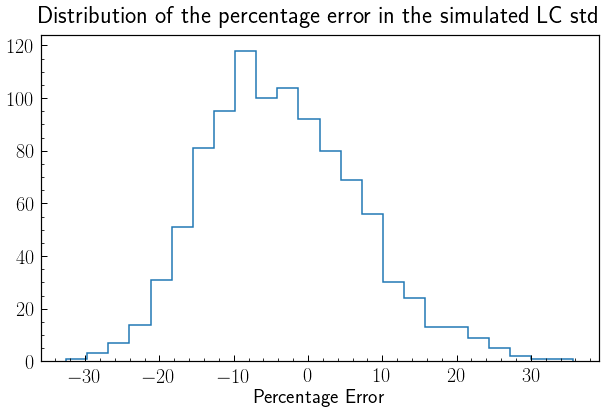

In [10]:
fig = plt.figure(figsize=(10,6))
_ = plt.hist(percent_err, bins='fd', histtype='step', linewidth=1.5)
plt.title('Distribution of the percentage error in the simulated LC std')
plt.xlabel('Percentage Error')

<span style='color:red'>The __conclusion__ is that light curves simulated by `celerite` will exhibit deviations from the desired ones in a way similar to light curves simulated by `Kali`. A walk around would be put the simulating process inside a if statement and exit the closure only when the standard deviation of the simulated process lie within a certain interval of the desired number.</span>

Text(0.5, 1.0, 'Sample Simulated DRW LC')

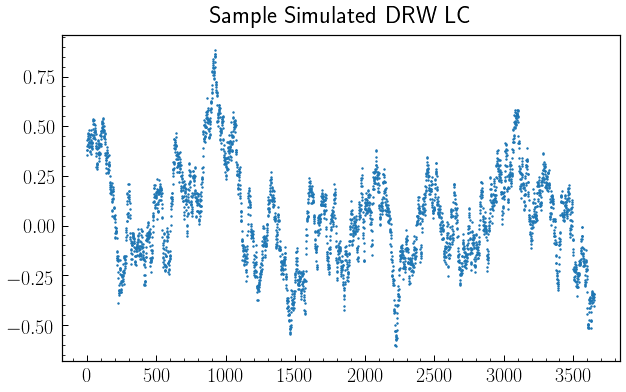

In [11]:
# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.scatter(t, y, s=2)
plt.title('Sample Simulated DRW LC')

### 1.2 Extend the above test to different ratios of LC length to $\tau$

In [12]:
# init an array of different taus
taus = np.logspace(1, np.log10(600), 15)

# init time stamps and errors
t = np.linspace(0, 3650, 1000)
yerr = np.random.normal(0, 1e-7, 1000) # give very tiny error

In [13]:
# iterate over different taus
n_lc = 1000
n_params = 15
percent_err_all = np.empty((n_params, n_lc))
for i, tau in enumerate(taus):
    # define GP model
    kernel = DRW_term(np.log(0.25), np.log(tau))
    gp = GP(kernel)
    gp.compute(t, yerr)
    y = gp.sample(size=n_lc)
    std = np.std(y, axis=1)
    percent_err_all[i,:] = 100*(std-0.25)/0.25

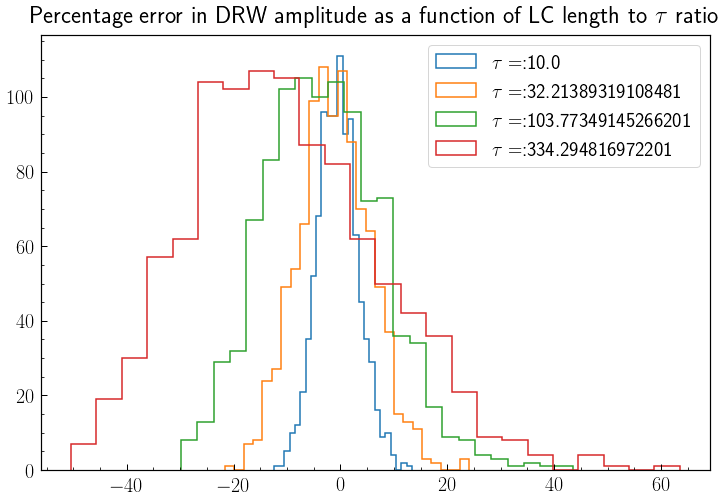

In [14]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(percent_err_all):
    if i%4 == 0:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'$\\tau=$:{taus[i]}')
plt.title('Percentage error in DRW amplitude as a function of LC length to $\\tau$ ratio')
plt.legend()

### 1.3 Extend to different number of data points in the cadence (while keeping the input params fixed)

In [15]:
n_points = [50, 100, 200, 400, 800, 1600]
n_combo = len(n_points)
percent_err_3 = np.empty((n_combo, n_lc))

for i, n_pt in enumerate(n_points):
    # define GP model
    kernel = DRW_term(np.log(0.25), np.log(103))
    gp = GP(kernel)
    
    # different n of pts for each iteration
    t = np.linspace(0, 3650, n_pt)
    yerr = np.random.normal(0, 1e-7, n_pt) # give very tiny error
    
    gp.compute(t, yerr)
    y = gp.sample(size=n_lc)
    std = np.std(y, axis=1)
    percent_err_3[i,:] = 100*(std-0.25)/0.25

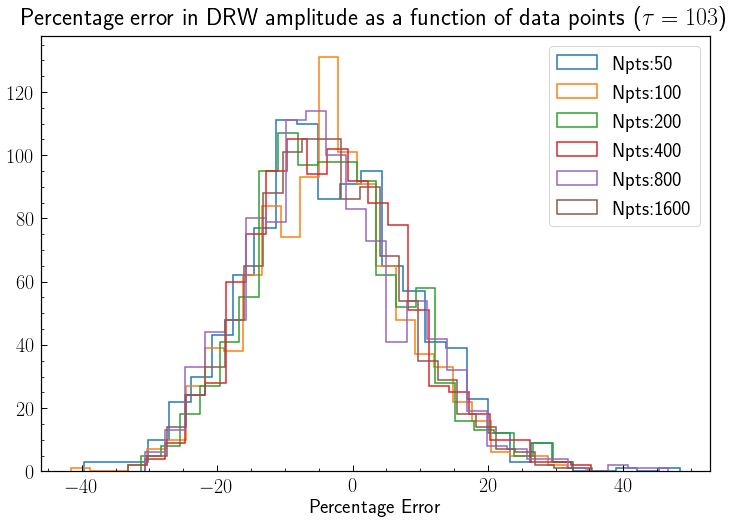

In [16]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(percent_err_3):
    _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'Npts:{n_points[i]}')
plt.title('Percentage error in DRW amplitude as a function of data points ($\\tau=103$)')
plt.xlabel('Percentage Error')
plt.legend()

In [17]:
# now test for smaller tau
percent_err_4 = np.empty((n_combo, n_lc))
for i, n_pt in enumerate(n_points):
    # define GP model
    kernel = DRW_term(np.log(0.25), np.log(15))
    gp = GP(kernel)
    
    # different n of pts for each iteration
    t = np.linspace(0, 3650, n_pt)
    yerr = np.random.normal(0, 1e-7, n_pt) # give very tiny error
    
    gp.compute(t, yerr)
    y = gp.sample(size=n_lc)
    std = np.std(y, axis=1)
    percent_err_4[i,:] = 100*(std-0.25)/0.25

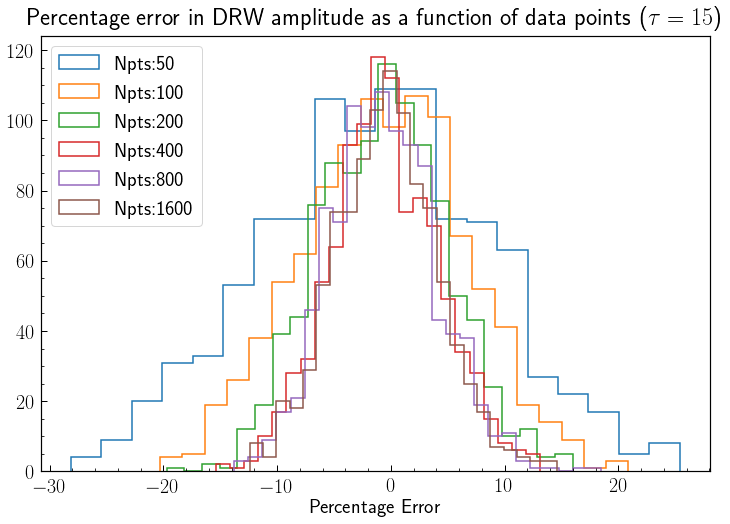

In [18]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(percent_err_4):
    _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'Npts:{n_points[i]}')
plt.title('Percentage error in DRW amplitude as a function of data points ($\\tau=15$)')
plt.xlabel('Percentage Error')
plt.legend()

<span style='color:red'> From the above two experiments we can conclude that with uniform samplings the accuracy of the simulated light curves doesn't change much if the minimum $\Delta t$ between two observations is not too close to the characteristic timescale. Next, let's see what if we use random sampling instead of uniform sampling, thus we can increase the coverage of the sampling the log($\Delta t$) space </span>

In [19]:
def downsample_byN(t, nObs):
    """Utility function to randomly choose N observation from a given light curves
    
    Args:
        t(array_like): Time stamp of observations in the original light curve.
        N(int): The number of observations in the final light curve.

    Returns:
        An mask of the original length to select data point.
    """
    
    # random choose index
    idx = np.arange(len(t))
    mask = np.zeros_like(idx, dtype=np.bool)
    true_idx = np.random.choice(idx, nObs, replace=False)
    
    # assign chosen index to 1/True
    mask[true_idx] = 1
    
    return mask

In [20]:
# now test for smaller tau
percent_err_rand = np.empty((n_combo, n_lc))

# different n of pts for each iteration
t_10000 = np.linspace(0, 3650, 100000)
yerr_10000 = np.random.normal(0, 1e-7, 100000) # give very tiny error

for i, n_pt in enumerate(n_points):
    # define GP model
    kernel = DRW_term(np.log(0.25), np.log(15))
    gp = GP(kernel)

    min_t = 100
    
    # while loop until minium dt is smaller than tau
    while min_t > 15:
        # different n of pts for each iteration
        mask = downsample_byN(t_10000, n_pt)
        t = t_10000[mask]
        yerr = yerr_10000[mask]
        # reset min_t
        min_t = np.min(t[1:] - t[0:-1])
    
    gp.compute(t, yerr)
    y = gp.sample(size=n_lc)
    std = np.std(y, axis=1)
    percent_err_rand[i,:] = 100*(std-0.25)/0.25

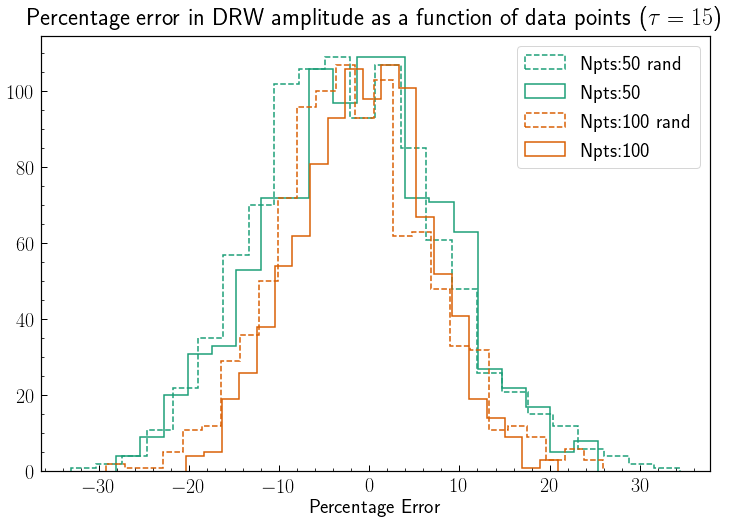

In [21]:
# now plot to compare
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(percent_err_rand[0:2]):
    _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'Npts:{n_points[i]} rand', \
                 linestyle='--', color=cm.Dark2.colors[i])
    _ = plt.hist(percent_err_4[i,:], bins='fd', histtype='step', linewidth=1.5, \
                 label=f'Npts:{n_points[i]}', color=cm.Dark2.colors[i])
plt.title('Percentage error in DRW amplitude as a function of data points ($\\tau=15$)')
plt.xlabel('Percentage Error')
plt.legend()

<span style='color:red'> The conclusion is that randomly picking observations from dense uniform sampling across the same baseline doesn't help with generating better simulated LCs, and this could also lead to simliar results in fitting later. So, if the accuracy on simulated LC is a good indication of how well we can sample a process given a range of number of data points, in order to best sample the underlying process, we need the average cadence (baseline/n_points) to be at least the same as the intrinsic characteristic timescale</span>

### 1.4 Test the effect of seasonal gaps using a fixed $\tau$
#### 1.4.1 Uniform sampling

In [22]:
def add_season(t, lc_start=0, season_start=90, season_end=270):
    """Utility function to impose seasonal gap in mock light curves
    
    Args:
        t(array_like): Time stamp of observations in a light curve.
        lc_start(float): Light curve starting day within a year (0 -> 365.25). Default to 0.
        season_start(float): Observing season start day within a year. Default to 90.
        season_end(float): Observing season end day within a year. Default to 270.

    Returns:
        An mask of the original length to select data point.
    """
    
    t = t - t[0]
    t = t + lc_start
    
    mask = (np.mod(t, 365.25) > season_start ) & (np.mod(t, 365.25) < season_end)

    return mask

In [23]:
taus

array([ 10.        ,  13.39710014,  17.94822921,  24.04542241,
        32.21389319,  43.1572753 ,  57.81823389,  77.45966692,
       103.77349145, 139.02638568, 186.25504109, 249.52774369,
       334.29481697, 447.8581139 , 600.        ])

In [ ]:
percent_err_sg = np.empty((len(taus), n_lc))

# different n of pts for each iteration
t_sg = np.linspace(0, 3650, 100000)
yerr_sg = np.random.normal(0, 1e-7, 100000) # give very tiny error

for i, tau in enumerate(taus):
    # define GP model
    kernel = DRW_term(np.log(0.25), np.log(tau))
    gp = GP(kernel)

    mask_1 = add_season(t_sg)
    ratio = np.int(sum(mask_1)/100)
    
    t = t_sg[mask_1][::ratio]
    yerr = yerr_sg[mask_1][::ratio]

    gp.compute(t, yerr)
    y = gp.sample(size=n_lc)
    std = np.std(y, axis=1)
    percent_err_sg[i,:] = 100*(std-0.25)/0.25

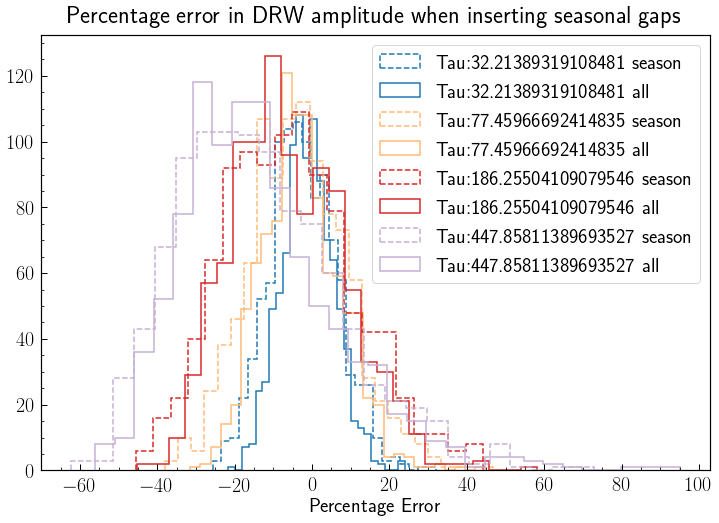

In [44]:
# now plot to compare
fig = plt.figure(figsize=(12,8))
start_idx = 4
cmap = cm.tab20
for i, err in enumerate(percent_err_sg[start_idx:]):
    if i%3 == 0:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, \
                     label=f'Tau:{taus[i+start_idx]} season', linestyle='--', color=cmap.colors[i])
        _ = plt.hist(percent_err_all[i+start_idx,:], bins='fd', histtype='step', 
                     linewidth=1.5, label=f'Tau:{taus[i+start_idx]} all', color=cmap.colors[i])
plt.title('Percentage error in DRW amplitude when inserting seasonal gaps')
plt.xlabel('Percentage Error')
plt.legend()

<span style='color:red'> From the test down above, we can see the addition of observing season did little to affect an accurate determination of the true amplitude of the underlying process. The majority of the error comes from the LC length to $\tau$ ratio. This is true if the average cadence is not worse than the $\tau$. In the above test, we tried to use an uniform cadence, next let's see how large is the effect of random sampling.</span>

#### 1.4.2 Random sampling

In [43]:
percent_err_sg_rand = np.empty((len(taus), n_lc))

# different n of pts for each iteration
t_sg = np.linspace(0, 3650, 100000)
yerr_sg = np.random.normal(0, 1e-7, 100000) # give very tiny error

for i, tau in enumerate(taus):
    # define GP model
    kernel = DRW_term(np.log(0.25), np.log(tau))
    gp = GP(kernel)

    mask_1 = add_season(t_sg)
    mask_2 = downsample_byN(t_sg[mask_1], 100)
    
    t = t_sg[mask_1][mask_2]
    yerr = yerr_sg[mask_1][mask_2]

    gp.compute(t, yerr)
    y = gp.sample(size=n_lc)
    std = np.std(y, axis=1)
    percent_err_sg_rand[i,:] = 100*(std-0.25)/0.25

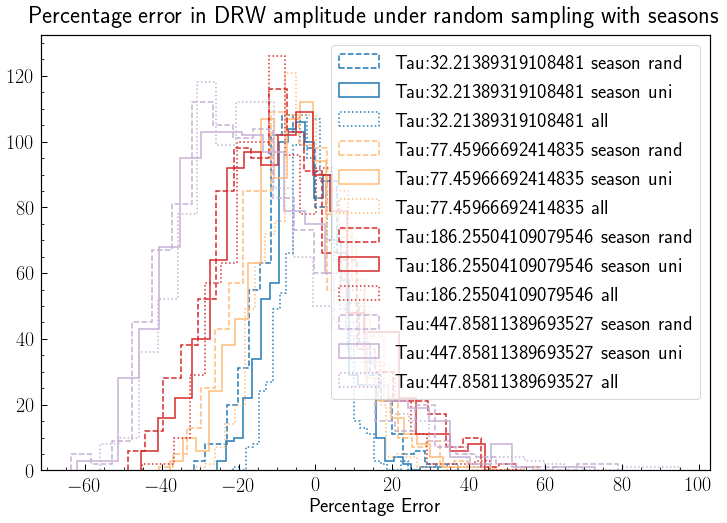

In [54]:
# now plot to compare
fig = plt.figure(figsize=(12,8))
start_idx = 4
cmap = cm.tab20
for i, err in enumerate(percent_err_sg_rand[start_idx:]):
    if i%3 == 0:
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, \
                     label=f'Tau:{taus[i+start_idx]} season rand', linestyle='--', color=cmap.colors[i])
        _ = plt.hist(percent_err_sg[i+start_idx,:], bins='fd', histtype='step', 
                     linewidth=1.5, label=f'Tau:{taus[i+start_idx]} season uni', color=cmap.colors[i])
        _ = plt.hist(percent_err_all[i+start_idx,:], bins='fd', histtype='step', linestyle=':',
             linewidth=1.5, label=f'Tau:{taus[i+start_idx]} all', color=cmap.colors[i])
plt.title('Percentage error in DRW amplitude under random sampling with seasons')
plt.xlabel('Percentage Error')
plt.legend()

<span style='color:red'> I think the main effect of seasonal gap and random sampling (instead of uniform) is broaderning the distribution. Not additional offset(shift) of the error distribution are introduced. The next step will be to verify if the error distribution stays unchaged for a variaty of random seed when applied the fitting.</span>